##  Modeling

### 1. Import packages and load the data

In [85]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer, make_column_transformer

In [86]:
jobs = pd.read_csv('data/jobs_data_step4_features.csv')
print(jobs.info())
print('There are {} observations and {} features in this dataset.'.format(jobs.shape[0],jobs.shape[1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047 entries, 0 to 2046
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rating             1960 non-null   float64
 1   Location           2047 non-null   object 
 2   Type of ownership  2037 non-null   object 
 3   Sector             1891 non-null   object 
 4   Revenue            1471 non-null   object 
 5   Years Founded      2047 non-null   float64
 6   Min_Salary         2047 non-null   int64  
 7   Max_Salary         2047 non-null   int64  
 8   Seniority          2047 non-null   object 
 9   HQ_Same            2047 non-null   int64  
 10  SQL                2047 non-null   int64  
 11  Excel              2047 non-null   int64  
 12  Python             2047 non-null   int64  
 13  Tableau            2047 non-null   int64  
 14  R                  2047 non-null   int64  
 15  SAS                2047 non-null   int64  
dtypes: float64(2), int64(9),

In [87]:
jobs.head()

,Rating,Location,Type of ownership,Sector,Revenue,Years Founded,Min_Salary,Max_Salary,Seniority,HQ_Same,SQL,Excel,Python,Tableau,R,SAS
0,3.2,NY,Nonprofit Organization,Non-Profit,$100 to $500 million (USD),59.0,37,66,Not specified,1,1,0,1,0,1,0
1,3.8,NY,Nonprofit Organization,Health Care,$2 to $5 billion (USD),127.0,37,66,Not specified,1,1,1,0,0,1,1
2,3.4,NY,Company - Private,Information Technology,NaN,17.0,37,66,Senior,1,1,1,0,1,0,0
3,4.1,NY,Subsidiary or Business Segment,Information Technology,$50 to $100 million (USD),18.0,37,66,Not specified,0,1,0,0,1,0,0
4,3.9,NY,Company - Private,"Arts, Entertainment & Recreation",$100 to $500 million (USD),11.0,37,66,Not specified,1,1,1,1,0,0,0


### 2.Train/Test Split

In [88]:
# Split data to predict Min_Salary
X_train, X_test, y_train1, y_test1 = train_test_split(jobs.drop(columns=['Min_Salary','Max_Salary']), 
                                                    jobs.Min_Salary, test_size=0.3, random_state=47)
# Split data to predict Max_Salary
X_train, X_test, y_train2, y_test2 = train_test_split(jobs.drop(columns=['Min_Salary','Max_Salary']), 
                                                    jobs.Max_Salary, test_size=0.3, random_state=47)

In [89]:
X_train.shape, X_test.shape

((1432, 14), (615, 14))

### 3.Refining The Linear Model

In the previous step, we've tried predicting salary with a linear regression model, and now we will refine our linear regression model with feature selection and evaluate the model using cross validation.

In [90]:
categorical_features = ['HQ_Same', 'SQL', 'Excel','Python','Tableau','R','SAS',
                 'Location','Type of ownership','Sector','Revenue','Seniority']
numerical_features = ['Rating', 'Years Founded']
preprocess = make_column_transformer(
    ( make_pipeline(SimpleImputer(strategy='median'), StandardScaler()),numerical_features),
    ( make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown='ignore')),categorical_features)
)

In [91]:
# linear regression without feature selection
pipe = make_pipeline(
    preprocess,
    LinearRegression()
)

In [92]:
pipe.fit(X_train, y_train1)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Rating', 'Years Founded']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
        

In [93]:
y_tr_pred1 = pipe.predict(X_train)
y_te_pred1 = pipe.predict(X_test)

In [94]:
print('r2 score on train set: ',r2_score(y_train1, y_tr_pred1), ', r2 score on test set: ', r2_score(y_test1, y_te_pred1))
print('mae on train set: ',mean_absolute_error(y_train1, y_tr_pred1), ', mae score on test set: ', mean_absolute_error(y_test1, y_te_pred1))
print('mse on train set: ',mean_squared_error(y_train1, y_tr_pred1), ', mse score on test set: ', mean_squared_error(y_test1, y_te_pred1))

r2 score on train set:  0.3285114387876167 , r2 score on test set:  0.2845302688137007
mae on train set:  11.774820025901679 , mae score on test set:  11.980053588560361
mse on train set:  255.76167997838022 , mse score on test set:  270.5876086680645


In [95]:
# Assessing performance using cross-validation
cv_results = cross_validate(pipe, X_train, y_train1, cv=5)
cv_scores = cv_results['test_score']
cv_scores

array([0.33482974, 0.26864631, 0.24532448, 0.23206794, 0.13907614])

In [96]:
np.mean(cv_scores),np.std(cv_scores)

(0.24398892417645413, 0.06326235299436937)

In [97]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([0.12, 0.37])

### 3.1 Lasso

#### 3.1.1 Lasso Baseline Model (Predicting Min_Salary)

In [98]:
# Lasso with alpha = 1.0 (default)
lasso_pipe = make_pipeline(
    preprocess,
    Lasso()
)

In [99]:
# Assessing performance using cross-validation
cv_results_lasso = cross_validate(lasso_pipe, X_train, y_train1, cv=5)
cv_scores_lasso = cv_results_lasso['test_score']
cv_scores_lasso

array([0.15491287, 0.15389161, 0.12963258, 0.13355017, 0.11548106])

In [100]:
np.mean(cv_scores_lasso),np.std(cv_scores_lasso)

(0.1374936596100442, 0.015061368413500519)

The default Lasso regression model yields worse performance than the linear regression model. Let's try tuning Lasso hyperparameters to see if we can get a better result.

#### 3.1.2 Hyperparameter search using GridSearchCV

In [101]:
# check available parameters in this pipeline
lasso_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'lasso', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__pipeline-1', 'columntransformer__pipeline-2', 'columntransformer__pipeline-1__memory', 'columntransformer__pipeline-1__steps', 'columntransformer__pipeline-1__verbose', 'columntransformer__pipeline-1__simpleimputer', 'columntransformer__pipeline-1__standardscaler', 'columntransformer__pipeline-1__simpleimputer__add_indicator', 'columntransformer__pipeline-1__simpleimputer__copy', 'columntransformer__pipeline-1__simpleimputer__fill_value', 'columntransformer__pipeline-1__simpleimputer__missing_values', 'columntransformer__pipeline-1__simpleimputer__strategy', 'columntransformer__pipeline-1__simpleimputer__verbose', 'columntransformer__pipeline-1__standardscaler__copy', 'columntransformer__pipel

In [102]:
# gird search alpha values between 0.0 and 1.0 with a grid separation of 0.01
lasso_cv = GridSearchCV(lasso_pipe, param_grid={'lasso__alpha': np.arange(0, 1, 0.01)}, cv=5, n_jobs=-1)

##### a) Predicting Min_Salary

In [103]:
lasso_cv.fit(X_train, y_train1)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Rating',
                                                                          'Years '
                                                                          'Founded']),
                                                                        ('pipeline-2',
                                         

In [104]:
score_mean = lasso_cv.cv_results_['mean_test_score']
score_std = lasso_cv.cv_results_['std_test_score']
cv_lasso = [l for l in lasso_cv.cv_results_['param_lasso__alpha']]

In [105]:
print('best alpha: ',lasso_cv.best_params_, ', which gives a mean cv score of', lasso_cv.best_score_)

best alpha:  {'lasso__alpha': 0.05} , which gives a mean cv score of 0.2630425713610481


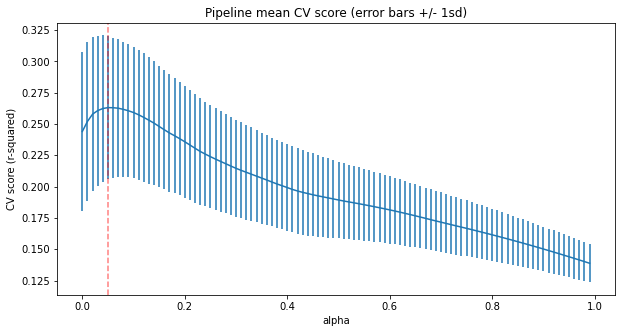

In [106]:
# plot mean CV score vs. alpha
best_lasso = lasso_cv.best_params_['lasso__alpha']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_lasso, score_mean, yerr=score_std)
plt.axvline(x=best_lasso, c='r', ls='--', alpha=.5)
plt.xlabel('alpha')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The above suggests a good alpha for our lasso model is 0.05.

In [107]:
lasso_estimator1 = lasso_cv.best_estimator_

In [108]:
# Assessing performance using cross-validation for prediction of y_train1: minimum salary
cv_best_lasso_1 = cross_validate(lasso_estimator1, X_train, y_train1, cv=5)['test_score']
np.mean(cv_best_lasso_1),np.std(cv_best_lasso_1)

(0.2630425713610481, 0.05703177953314068)

Recall that the default lasso model gave a mean cv score of 0.137, it's obvious that for prediction on Min_Salary, choosing alpha = 0.05 has greatly improved the lasso model performance.

##### b) Predicting Max_Salary

In [109]:
lasso_cv.fit(X_train, y_train2)
print(lasso_cv.best_params_)

{'lasso__alpha': 0.08}


In [110]:
lasso_estimator2 = lasso_cv.best_estimator_

In [111]:
# Assessing performance using cross-validation for prediction of y_train2: maximum salary
print(np.mean(cross_validate(lasso_cv.best_estimator_, X_train, y_train2, cv=5)['test_score']),
      np.std(cross_validate(lasso_cv.best_estimator_, X_train, y_train2, cv=5)['test_score']))

0.25476214186257157 0.05141595297613488


When predicting for maximum salary, the best alpha for lasso is 0.08, which gives a mean r-squared score of 0.254 with 0.051 standard deviation. 

#### 3.1.3 Which features were most useful? 

In [112]:
# define a function to get feature names from our pipeline
import sklearn
import warnings

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

# Code adapted from:
# https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html

In [113]:
feature_names = get_feature_names(preprocess)

<ipython-input-112-7c9e8dd463e5>:34: UserWarning: Transformer simpleimputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-112-7c9e8dd463e5>:34: UserWarning: Transformer standardscaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [114]:
lasso_coefs = lasso_estimator1.named_steps.lasso.coef_

In [115]:
# Display the top 30 most important features selected by lasso and thier correspnding coefficients
pd.DataFrame({'coefs':lasso_coefs,'The absolute value of coefs':abs(lasso_coefs)}, 
             index=get_feature_names(preprocess)).sort_values('The absolute value of coefs',ascending=False).head(30)

<ipython-input-112-7c9e8dd463e5>:34: UserWarning: Transformer simpleimputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-112-7c9e8dd463e5>:34: UserWarning: Transformer standardscaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


,coefs,The absolute value of coefs
onehotencoder__x7_IL,20.885350,20.885350
onehotencoder__x7_CA,19.458577,19.458577
onehotencoder__x7_UT,-16.180112,16.180112
onehotencoder__x7_OH,-11.761645,11.761645
onehotencoder__x7_CO,10.928651,10.928651
onehotencoder__x7_NY,8.896904,8.896904
onehotencoder__x7_NJ,7.758899,7.758899
onehotencoder__x9_Media,-7.746343,7.746343
onehotencoder__x7_IN,-7.411508,7.411508
onehotencoder__x10_$1 to $5 million (USD),3.494513,3.494513


These results suggest that Location_CA and Location_IL are our biggest positive features, and Location_UT and Location_OH are our biggest negative features.

### 4.Random Forest Model

#### 4.1 Random Forest Baseline Model (Precdicting Min_Salary)

In [116]:
# Define the pipeline for a random forest baseline model
rf_pipe = make_pipeline(
    preprocess,
    RandomForestRegressor(random_state=47)
)

In [117]:
rf_default_cv_results = cross_validate(rf_pipe, X_train, y_train1, cv=5)

In [118]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.27697319, 0.23350682, 0.22367662, 0.13702231, 0.00042933])

In [119]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.17432165442000916, 0.09808762916537621)

The test score doesn't seem good enough. Random forest has a number of hyperparameters that can be explored, so let's see how we can improve this model by tuning the hyperparameters.  
Since this data set is not large (about 2000 samples), the grid search may outperform the random search. Therefore, I'll just go straight to use GridSearchCV to search for the best hyperparameters.

#### 4.2 Hyperparameter search using GridSearchCV

In [120]:
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)

rf_param_grid = {
    'randomforestregressor__max_depth': max_depth,
    'randomforestregressor__max_features': ['auto', 'sqrt'],
    'randomforestregressor__n_estimators': [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
}
rf_param_grid

{'randomforestregressor__max_depth': [10, 32, 55, 77, 100, None],
 'randomforestregressor__max_features': ['auto', 'sqrt'],
 'randomforestregressor__n_estimators': [10,
  120,
  230,
  340,
  450,
  560,
  670,
  780,
  890,
  1000]}

In [121]:
rf_grid_cv = GridSearchCV(rf_pipe, param_grid=rf_param_grid, cv=5, n_jobs=-1)

##### a) Predicting Min_Salary

In [122]:
rf_grid_cv.fit(X_train, y_train1)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Rating',
                                                                          'Years '
                                                                          'Founded']),
                                                                        ('pipeline-2',
                                         

In [123]:
rf_grid_cv.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__n_estimators': 780}

In [124]:
rf_estimator1 = rf_grid_cv.best_estimator_

In [125]:
# Assessing performance using cross-validation for prediction of y_train1: minimum salary
rf_best_cv_results = cross_validate(rf_estimator1, X_train, y_train1, cv=5)
print(np.mean(rf_best_cv_results['test_score']), np.std(rf_best_cv_results['test_score']))

0.23443077574409593 0.034270713490133456


To determine if the grid search yielded a better model, we compare the best random forestgrid search model with our random forest base model.

Recall that our random forest base model gave a mean test score of 0.17432165442000916 and 0.09808762916537621 standard deciation. Comparing to the random forest base model, the grid search we've done yielded a better result.

##### b) Predicting Max_Salary

In [153]:
rf_grid_cv.fit(X_train, y_train2)
print(rf_grid_cv.best_params_)

{'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 340}


In [154]:
rf_estimator2 = rf_grid_cv.best_estimator_

In [155]:
# Assessing performance using cross-validation for prediction of y_train2: maximum salary
print(np.mean(cross_validate(rf_estimator2, X_train, y_train2, cv=5)['test_score']),
      np.std(cross_validate(rf_estimator2, X_train, y_train2, cv=5)['test_score']))

0.28971017949258177 0.05772130309239363


When predicting for maximum salary, the best parameters for random forest are {max_depth:10, max_featues:'auto', n_estimators: 340}, which gives a mean r-squared score of 0.290 with 0.058 standard deviation.

#### 4.3 Feature Importance

<ipython-input-112-7c9e8dd463e5>:34: UserWarning: Transformer simpleimputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-112-7c9e8dd463e5>:34: UserWarning: Transformer standardscaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


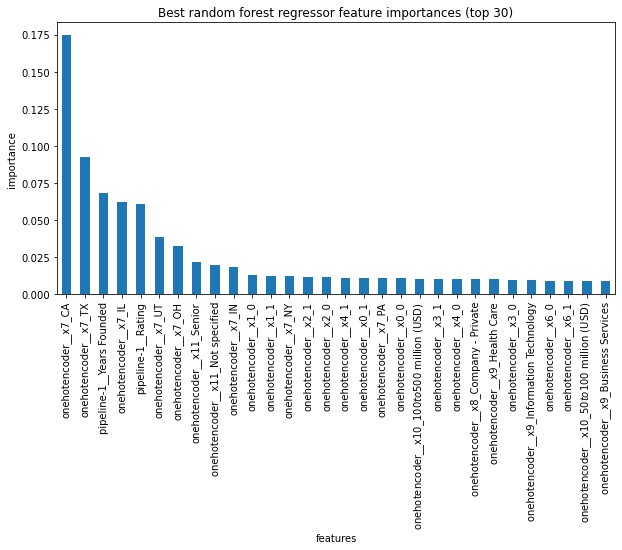

In [156]:
#Plot a barplot of the random forest's feature importances (display the top 30 most important features only)
plt.subplots(figsize=(10, 5))
importances = rf_estimator1.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(importances, index=get_feature_names(preprocess)).sort_values(ascending=False).head(30)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances (top 30)');

We can see that the dominant top five features are
- Location_CA
- Location_TX
- YearsFounded
- Location_IL 
- Rating 

Both of the lasso and random forest models show that the locations CA and IL are very important features; furthermore, the features 'YearsFounded' and 'Rating' are shown to be important by the random forest model as well, while they don't seem important at all for the lasso model.

Let's try out another modeling method called Support Vector Regression(SVR), which is built based on the concept of Support Vector Machine(SVM)

### 5.Support Vector Regression (SVR)

#### 5.1 SVR Baseline Model (Predicting Min_Salary)

In [157]:
# Define the pipeline for a SVR baseline model (using the default kernel 'rbf' and default parameters C=1.0 and epsilon=0.1)
svr_pipe = make_pipeline(
    preprocess,
    SVR()
)

In [158]:
# Assessing performance using cross-validation
cv_results_svr = cross_validate(svr_pipe, X_train, y_train1, cv=5)
print(np.mean(cv_results_svr['test_score']), np.std(cv_results_svr['test_score']))

0.09201876634729855 0.025904570860198605


The default SVR model doesn't perform that well. Let's try tuning some hyperparameters to see if we can get a better result.

#### 5.2 Hyperparameter search using GridSearchCV

In [159]:
svr_grid_cv = GridSearchCV(svr_pipe,param_grid={'svr__epsilon':[0.01,0.1,1,5,10],'svr__C': np.arange(1, 30, 2)}, cv=5, n_jobs=-1)

##### a) Predicting Min_Salary

In [160]:
svr_grid_cv.fit(X_train,y_train1)
print(svr_grid_cv.best_params_)

{'svr__C': 21, 'svr__epsilon': 5}


In [161]:
svr_estimator1 = svr_grid_cv.best_estimator_

In [162]:
# Assessing pesvrormance using cross-validation for prediction of y_train1: minimum salary
svr_best_cv_results1 = cross_validate(svr_estimator1, X_train, y_train1, cv=5)
svr_best_scores1 = svr_best_cv_results1['test_score']
print(np.mean(svr_best_scores1), np.std(svr_best_scores1))

0.22591692844684746 0.03843075194624622


The new SVR model now perform much better than the default SVR model for prediction on minimum salary

##### b) Predicting Max_Salary

In [163]:
svr_grid_cv.fit(X_train,y_train2)
print(svr_grid_cv.best_params_)

{'svr__C': 29, 'svr__epsilon': 10}


In [164]:
svr_estimator2 = svr_grid_cv.best_estimator_

In [166]:
# Assessing pesvrormance using cross-validation for prediction of y_train2: maximum salary
svr_best_scores2 = cross_validate(svr_estimator2, X_train, y_train2, cv=5)['test_score']
print(np.mean(svr_best_scores2), np.std(svr_best_scores2))

0.25593930377326535 0.032587849388802416


When predicting for maximum salary, the best parameters for SVR are {C:29, epsilon: 10}, which gives a mean r-squared score of 0.256 with 0.032 standard deviation.

### 6.Final Model Selection

I've built a best lasso model, a best random forest model, and a best SVR model for prediction on minimum salary; also, I've built a best lasso model, a best random forest model, and a best SVR model for prediction on maximum salary. Now I need to finally choose the best model for minimum salary prediction and the best model for maximum salary prediction. I'll calculate the mean absolute error using cross-validation.

#### 6.1 Selecting Model for Minimum Salary Prediction

#### 6.1.1 Lasso Regression Model

In [167]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error -- predicting y_train1
lasso_neg_mae1 = cross_validate(lasso_estimator1, X_train, y_train1, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
print(np.mean(-1 * lasso_neg_mae1['test_score']), np.std(-1 * lasso_neg_mae1['test_score']))

12.254578816860093 0.3305864161239016


In [168]:
# mean absolute error -- predicting y_test1
mean_absolute_error(y_test1, lasso_estimator1.predict(X_test))

11.722781673767358

#### 6.1.2 Random forest regression model performance

In [169]:
# mean absolute error -- predicting y_train1
rf_neg_mae1 = cross_validate(rf_estimator1, X_train, y_train1, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
print(np.mean(-1 * rf_neg_mae1['test_score']), np.std(-1 * rf_neg_mae1['test_score']))

12.725361927552617 0.3199203726693101


In [170]:
# mean absolute error -- predicting y_test1
mean_absolute_error(y_test1, rf_estimator1.predict(X_test))

12.169583016872549

#### 6.1.3 Support Vector Regression model performance

In [171]:
# mean absolute error -- predicting y_train1
svr_neg_mae1 = cross_validate(svr_estimator1, X_train, y_train1, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
print(np.mean(-1 * svr_neg_mae1['test_score']), np.std(-1 * svr_neg_mae1['test_score']))

12.318950861586748 0.4727860370105882


In [172]:
# mean absolute error -- predicting y_test1
mean_absolute_error(y_test1, svr_estimator1.predict(X_test))

12.020551499218984

#### 6.2 Selecting Model for Maximum Salary Prediction

#### 6.2.1 Lasso Regression Model

In [173]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error -- predicting y_train2
lasso_neg_mae2 = cross_validate(lasso_estimator2, X_train, y_train2, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
print(np.mean(-1 * lasso_neg_mae2['test_score']), np.std(-1 * lasso_neg_mae2['test_score']))

19.231908145706264 0.4269983820543316


In [174]:
# mean absolute error -- predicting y_test2
mean_absolute_error(y_test2, lasso_estimator2.predict(X_test))

18.265554154797098

#### 6.2.2 Random forest regression model performance

In [175]:
# mean absolute error -- predicting y_train2
rf_neg_mae2 = cross_validate(rf_estimator2, X_train, y_train2, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
print(np.mean(-1 * rf_neg_mae2['test_score']), np.std(-1 * rf_neg_mae2['test_score']))

18.661243300897205 0.49186941108268556


In [176]:
# mean absolute error -- predicting y_test2
mean_absolute_error(y_test2, rf_estimator2.predict(X_test))

18.150492727460204

#### 6.2.3 Support Vector Regression model performance

In [177]:
# mean absolute error -- predicting y_train2
svr_neg_mae2 = cross_validate(svr_estimator2, X_train, y_train2, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
print(np.mean(-1 * svr_neg_mae2['test_score']), np.std(-1 * svr_neg_mae2['test_score']))

19.300271456566843 0.3919093747512375


In [178]:
# mean absolute error -- predicting y_test2
mean_absolute_error(y_test2, svr_estimator2.predict(X_test))

18.83455646357982

#### 6.4 Conclusion

For minimum salary prediction, the Lasso Regressin model gives the smallest MAE score, so it's the best among the three.  
For maximum salary prediction, the Random Forest model gives the smallest MAE score, so it's the best among the three.

In [179]:
# save the lasso model to the variable 'best_model_min' for minimum salary prediction
best_model_min = lasso_estimator1
best_model_min

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Rating', 'Years Founded']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
        

In [180]:
# save the random forest model to the variable 'best_model_max' for maximum salary prediction
best_model_max = rf_estimator2
best_model_max

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Rating', 'Years Founded']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
        

### 7.Summary

In order to predict the minimum salary and maximum salary for data analyst jobs, here we have considered 16 features.  

This is a regression problem. Here we have tried the following regression models:

- Linear Regression model (without regularization)
- Lasso Regression model
- Random Forest Regression model 
- Support Vector Regression (SVR)

Evaluating the performance of a model by training and testing on the same dataset can lead to overfitting. To prevent that, Cross-Validation technique is used where under the k-fold CV approach, the training set is split into k smaller sets, where a model is trained using k-1 of the folds as training data and the model is validated on the remaining part.  

We've first tried using models with their default parameters to predict minimum salary, and we've evaluated their performances in terms of r-squared score using cross-validation.

Next, we have carried out the grid search CV for the hyperparameter tuning for all models seperately except for the linear regression model. This step was the most time consuming one in terms of computation. (The RF model took much longer time). With the result of the optimized hyperparameters, we have again fitted our models on the training data. We have evaluated the r-squared score with the optimized hyperparameters. Clearly, the model performances have improved with the optimized parameters. The final mean r-squared score for best Lasso, best RF, and best SVR models by cross-validation are 0.263,0.234,and 0.226, when predicting the minimum salary.

It's worth noting the both our Lasso and Random Forest models showed that the locations CA and IL have a big positive impact on data analyst salary, and the locations UT ad OH have negative impact on data analyst salary. Moreover, the features YearsFounded and Rating were also shown to be imoortant by our Random Forest model.

Finally, we have evaluated each models in terms of mean absolute error for both the training and test data using cross validation. We chose the Lasso Regressin model for minimum salary prediction since it gave the smallest MAE score(11.72), and for maximum salary prediction, we chose the Random Forest model for the same reason(MAE=18.15). Additionally, both our chosen models gave the best r-squared scores.

Therefor, if we use our chosen models for salary prediction, when predicting minimum salary, it's expected to be off by \\$11K; when predicting maximum salary, it's expected to be off by $18K.

